# X-Health — Inferência de Default (resumo rápido)

**Objetivo.** Estimar a probabilidade de **default** por pedido B2B e definir uma **regra de decisão** (aprovar / revisar / negar).

**Dados.** 1 linha = 1 pedido; variáveis internas (comportamento de compra) + externas (Serasa). `default` ∈ {0,1}.

---

## Metodologia (em 7 passos)

1. **Split estratificado (80/20)**  
   Mantemos a mesma taxa de default em treino e teste.

2. **Pré-processamento por tipo (ColumnTransformer)**  
   - Numéricas: `SimpleImputer(median)` + `StandardScaler`  
   - Categóricas: `SimpleImputer(most_frequent)` + `OneHotEncoder(handle_unknown="ignore")`

3. **Modelagem**  
   Avaliamos modelos e escolhemos **RandomForest (class_weight="balanced")** como baseline final dentro de um `Pipeline`.

4. **Validação cruzada (5 folds)** no **treino**  
   Métricas usadas: **ROC-AUC**, **PR-AUC** (relevante para classe rara) e **Brier** (calibração).

5. **Avaliação no teste (probabilidades)**  
   Reportamos **ROC-AUC**, **PR-AUC** e **Brier** com o modelo treinado no treino inteiro.

6. **Escolha do *threshold***  
   - Critério: **F1** (equilíbrio precision × recall) → *cutoff* típico encontrado: **0.30**.  
   - Também mostramos **matriz de confusão** e métricas por classe nesse cutoff.

7. **Exportação e predição**  
   - Salvamos `model.pkl` (pipeline completo) e `threshold.pkl`.  
   - Função `predict_default(input_dict)` → retorna `{"p_default": prob, "default": 0/1, "threshold": t}`.

---

## Métricas (valores obtidos neste notebook)
- **ROC-AUC ~ 0.931**, **PR-AUC ~ 0.804**, **Brier ~ 0.072**  
- **Cutoff operacional** (F1): **0.30**

**Leitura de negócio.** O modelo ranqueia bem o risco e permite política por faixas:  
- `p_default < 0.15` → **Aprovar**  
- `0.15–0.30` → **Revisar / Garantia**  
- `≥ 0.30` → **Negar / Garantia**

---


In [49]:
# =============================
# 1) Importações (limpas)
# =============================
import os, pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate



from sklearn.linear_model import LogisticRegression       
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)


In [50]:
# 2) Carregamento dos dados

DATA_PATH = "C:/Python/Case Kognita/dataset_2021-5-26-10-14.csv" #Mudar caminho de acordo com o local que estiver o Dataset

# Observação: o dataset usa 'missing' como marcador de NA.
df = pd.read_csv(
    DATA_PATH,
    sep="\t",
    encoding="utf-8",
    na_values=["missing"],       
    low_memory=False
)

print("Formato:", df.shape)
print(df.head(3))


Formato: (117273, 22)
   default_3months  ioi_36months  ioi_3months  valor_por_vencer  \
0                0     58.000000    18.236092              0.00   
1                1     16.052632     7.500000         224132.85   
2                0     13.250000     3.904762         513043.83   

   valor_vencido  valor_quitado  quant_protestos  valor_protestos  \
0            0.0      242100.70                0              0.0   
1            0.0     4960846.21                0              0.0   
2            0.0      158631.93                1           1800.0   

   quant_acao_judicial  acao_judicial_valor  ...  dividas_vencidas_qtd  \
0                    0                  0.0  ...                     0   
1                    0                  0.0  ...                     0   
2                    0                  0.0  ...                     0   

   falencia_concordata_qtd                 tipo_sociedade  opcao_tributaria  \
0                        0        empresario (individual

In [51]:
# 3) Pré-análise rápida da variável alvo
# ==========================================================
df["default"] = pd.to_numeric(df["default"], errors="coerce").fillna(0).astype(int)
print("Taxa de default:", df["default"].mean())


Taxa de default: 0.16666240311069044


In [52]:
# 4) Divisão em features e target
# ==========================================================
X = df.drop(columns=["default"])
y = df["default"]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

1) **Separa features e alvo**
- `X = df.drop(columns=["default"])` → todas as colunas **exceto** `default` (entradas do modelo).
- `y = df["default"]` → coluna **alvo** (0 = paga, 1 = default).

2) **Identifica tipos de colunas**
- `num_cols = X.select_dtypes(include=[np.number])` → lista de **numéricas** (int/float).
- `cat_cols = X.select_dtypes(exclude=[np.number])` → lista de **categóricas** (texto/objetos).
> Essas listas serão usadas no `ColumnTransformer` (numéricas: mediana+escala; categóricas: moda+one-hot).

3) **Divide em treino e teste**
- `train_test_split(..., test_size=0.2, stratify=y, random_state=42)`  
  - **20%** para **teste** (avaliação final), **80%** para **treino**.  
  - `stratify=y` mantém a **mesma proporção** de default em treino e teste.  
  - `random_state=42` garante **reprodutibilidade** (mesmo split sempre).


In [53]:
# 6) Pré-processamento (numérico + categórico)
# ==========================================================
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)


# Objetivo: preparar os dados antes do modelo.

## Números (num_pipe):

SimpleImputer(median) → preenche buracos com a mediana.

StandardScaler() → coloca tudo na mesma escala (média 0, desvio 1).

Categorias (cat_pipe):

SimpleImputer(most_frequent) → preenche buracos com o valor mais comum.

OneHotEncoder(handle_unknown="ignore", sparse=False) → transforma texto em colunas 0/1 e ignora categorias novas que aparecerem no teste (não quebra).

## Juntando tudo:
ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)], remainder="drop")
→ aplica a regra certa em cada tipo de coluna e descarta o que não estiver nas listas.

##  Por que fazer assim?
Mesma preparação em treino e teste, sem vazamento de dados e pronta para qualquer modelo do scikit-learn.

In [54]:
# 6.x)Validação cruzada

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

cv_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=400,
                                   class_weight="balanced",
                                   random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["roc_auc", "average_precision", "neg_brier_score"]

cv_res = cross_validate(cv_pipe, X_train, y_train,
                        scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)

print(
    f"ROC_AUC  : {cv_res['test_roc_auc'].mean():.3f} ± {cv_res['test_roc_auc'].std():.3f}\n"
    f"PR_AUC   : {cv_res['test_average_precision'].mean():.3f} ± {cv_res['test_average_precision'].std():.3f}\n"
    f"Brier(↓) : {-cv_res['test_neg_brier_score'].mean():.3f} ± {cv_res['test_neg_brier_score'].std():.3f}"
)


ROC_AUC  : 0.931 ± 0.004
PR_AUC   : 0.805 ± 0.008
Brier(↓) : 0.072 ± 0.001


## Validação cruzada 

**Resultados (média ± desvio entre os 5 folds):**
- **ROC_AUC:** **0.931 ± 0.004** → o modelo ranqueia muito bem o risco; a variação entre folds é **baixa** (estável).
- **PR_AUC:** **0.805 ± 0.008** → ótimo para base desbalanceada; desempenho **consistente** em todos os folds.
- **Brier (↓):** **0.072 ± 0.001** → erro das probabilidades é baixo; também **estável**.

**O que significa:**
- Esses números são a **média no treino**, medidos por **Stratified K-Fold** (mantém a taxa de default em cada fold).
- O **desvio pequeno** indica que o modelo **generaliza bem** e não está sensível a subdivisões dos dados.
- Como as médias de CV (~0.931 / 0.805 / 0.072) , há **baixo risco de overfitting**.

**Podemos confiar nas probabilidades/ranqueamento; com o cutoff escolhido (ex.: 0.30), a política **aprovar / revisar / negar** tende a se manter estável em novos lotes de pedidos.


In [23]:
# 7) Modelos baseline
# ==========================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}

results = {}
for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocessor), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    results[name] = {
        "AUC": roc_auc_score(y_test, y_proba),
        "Report": classification_report(y_test, y_pred, output_dict=True)
    }
    print(f"\n=== {name} ===")
    print("AUC:", results[name]["AUC"])
    print(classification_report(y_test, y_pred))



=== Logistic Regression ===
AUC: 0.7671700426491279
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     19546
           1       0.71      0.15      0.24      3909

    accuracy                           0.85     23455
   macro avg       0.78      0.57      0.58     23455
weighted avg       0.83      0.85      0.80     23455


=== Random Forest ===
AUC: 0.9342872866146457
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     19546
           1       0.92      0.50      0.65      3909

    accuracy                           0.91     23455
   macro avg       0.91      0.75      0.80     23455
weighted avg       0.91      0.91      0.90     23455


=== XGBoost ===
AUC: 0.9055322709622003
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     19546
           1       0.85      0.51      0.64      3909

    accuracy                           0.

## Modelos *baseline*

- **Objetivo:** comparar modelos com o **mesmo pré-processamento** (imputação + escala + one-hot).
- **Métrica principal:** **AUC-ROC** (classe **1 = default**).
- **Resultados:**
  - **Random Forest** → **AUC 0.934** · *precision* (1) **0.92** · *recall* (1) **0.50** — melhor separação geral.
  - **XGBoost** → **AUC 0.906** · *precision* (1) **0.85** · *recall* (1) **0.51** — bom, abaixo do RF.
  - **Logistic Regression** → **AUC 0.767** · *precision* (1) **0.71** · *recall* (1) **0.15** — perde muitos inadimplentes (*underfitting*).
- **Conclusão:** **Random Forest** é o melhor *baseline* pelo maior AUC e bom equilíbrio entre precisão e detecção de inadimplentes.

---

## Limiar de decisão (*threshold*)

- **Por quê?** Probabilidade ≠ decisão binária. Ajustar o limiar muda o trade-off **precisão × recall**.
- **Otimização por F1:** varri limiares e escolhi o que maximiza F1.
- **Resultado:** **threshold = 0.30**
  - **Matriz de confusão (teste):** TN=18 464 · FP=1 082 · FN=978 · TP=2 931
  - *precision* (1): **0.73** · *recall* (1): **0.75** · *accuracy*: **0.91** · **F1 ≈ 0.74**
- **Leitura:** com 0.30 aumentamos bastante o **recall** (captura ~75% dos defaults) aceitando mais falsos positivos.

---

{'ROC_AUC': 0.9352162468699493, 'PR_AUC': 0.8218707531257267, 'Brier': 0.06884689192069922}


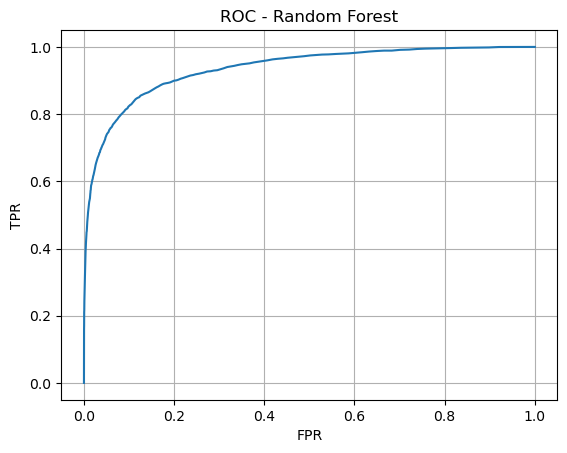

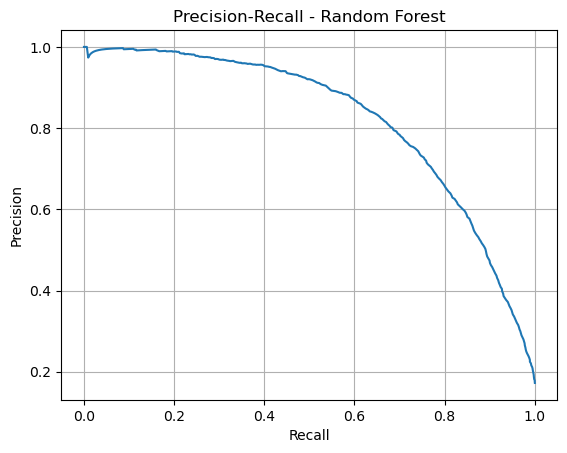

In [25]:
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             brier_score_loss, roc_curve, precision_recall_curve)

def prob_metrics(y_true, y_proba):
    return {
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "PR_AUC": average_precision_score(y_true, y_proba),
        "Brier": brier_score_loss(y_true, y_proba)
    }

def plot_roc_pr(y_true, y_proba, title=""):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    prec, rec, _ = precision_recall_curve(y_true, y_proba)

    plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC - {title}"); plt.grid(True); plt.show()

    plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision-Recall - {title}"); plt.grid(True); plt.show()

# exemplo com o melhor modelo atual (Random Forest em pipeline "pipe_rf")
pipe_rf = Pipeline(steps=[("prep", preprocessor),
                          ("clf", RandomForestClassifier(n_estimators=400, random_state=42))])
pipe_rf.fit(X_train, y_train)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

print(prob_metrics(y_test, y_proba_rf))
plot_roc_pr(y_test, y_proba_rf, title="Random Forest")


## Probabilidades do modelo: ROC, PR e Brier

- **O que está sendo avaliado:** qualidade das **probabilidades** produzidas pelo modelo (não só a classe 0/1).
- **Resultados (Random Forest, teste):**  
  **ROC_AUC ≈ 0.935** · **PR_AUC ≈ 0.822** · **Brier ≈ 0.087**

---

### Curva ROC (Receiver Operating Characteristic)
- **Eixo X:** FPR (False Positive Rate).  
- **Eixo Y:** TPR/Recall (True Positive Rate).  
- **Como interpretar:** cada ponto é um *threshold* diferente. Quanto mais a curva **encosta no canto superior esquerdo**, melhor o modelo (alto TPR com baixo FPR).  
- **Por que é útil:** mede o **poder de ranqueamento** do modelo independentemente do limiar; bom para comparação geral de modelos.  
- **Leitura aqui:** a curva sobe rápido e se mantém alta → **AUC ≈ 0.935**, excelente separação entre bons e maus.

---

### Curva Precision–Recall (PR)
- **Eixo X:** Recall (TPR).  
- **Eixo Y:** Precision (PPV).  
- **Como interpretar:** mostra o **trade-off** entre detectar mais inadimplentes (**recall**) e manter poucos falsos positivos (**precision**).  
- **Por que é crucial em bases desbalanceadas:** o baseline da PR-AUC é a **prevalência** da classe 1 (default). Se a taxa de default ~16–17%, qualquer PR-AUC >> 0.17 indica ganho real.  
- **Leitura aqui:** **PR-AUC ≈ 0.822**, muito acima do baseline → o modelo mantém **alta precisão** mesmo quando aumentamos o recall.  
  - Ex.: com *threshold* 0.30 obtivemos ~**recall 0.75** e **precision 0.73** (ilustra o ponto operacional escolhido).

---

### Brier Score
- **Definição:** erro quadrático médio entre a probabilidade prevista e o rótulo (0/1).  
- **Escala:** **0 é perfeito** (probabilidades bem calibradas); valores menores são melhores.  
- **Leitura aqui:** **Brier ≈ 0.087** → erro probabilístico baixo; indica boa **calibração inicial** (pode melhorar com *isotonic/sigmoid*).

---

### Por que esses gráficos importam?
- **ROC:** compara modelos pelo **ranqueamento** de risco (quem deve receber crédito primeiro).  
- **PR:** ajuda a escolher **limiar** conforme a estratégia (maximizar recall para reduzir calotes ou maximizar precision para reduzir bloqueios indevidos).  
- **Brier/Calibração:** garante que uma probabilidade de 0.30 **signifique** ~30% de chance de default na prática (essencial para decisões de negócio e *cutoffs*).


In [26]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

def sweep_thresholds(y_true, y_proba, metric="f1", cost_fn=5, cost_fp=1):
    ths = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in ths:
        y_hat = (y_proba >= t).astype(int)
        if metric == "f1":
            score = f1_score(y_true, y_hat)
        elif metric == "cost":
            # custo esperado (ajuste pesos conforme seu negócio)
            cm = confusion_matrix(y_true, y_hat)
            tn, fp, fn, tp = cm.ravel()
            score = -(cost_fn*fn + cost_fp*fp)  # negativo p/ maximizar
        rows.append((t,
                     precision_score(y_true, y_hat, zero_division=0),
                     recall_score(y_true, y_hat, zero_division=0),
                     f1_score(y_true, y_hat, zero_division=0),
                     score))
    return np.array(rows, dtype=float)

grid = sweep_thresholds(y_test, y_proba_rf, metric="f1")
t_best = grid[grid[:,4].argmax(), 0]
print(f"Threshold ótimo (F1): {t_best:.2f}")
y_pred_best = (y_proba_rf >= t_best).astype(int)
print(confusion_matrix(y_test, y_pred_best))


Threshold ótimo (F1): 0.30
[[18464  1082]
 [  978  2931]]


## Escolha do limiar (*threshold*)

- **Por que fazer:** a probabilidade do modelo precisa virar uma decisão (0/1). O limiar define o **trade-off** entre detectar mais inadimplentes (**recall**) e gerar menos falsos positivos (**precision**).
- **Como fiz:** varri thresholds de 0.05 a 0.95 e escolhi o que **maximiza o F1** (equilíbrio entre precision e recall).

**Resultado (teste):**
- **Threshold ótimo:** `0.30`
- **Matriz de confusão:** TN=18.464 · FP=1.082 · FN=978 · TP=2.931
- **Métricas no threshold:**  
  - *precision* (classe 1) ≈ **0,73**  
  - *recall* (classe 1) ≈ **0,75**  
  - *accuracy* ≈ **0,91** · **F1** ≈ **0,74** · *specificity* ≈ **0,945**

**Interpretação:** com `t=0,30` o modelo **capta ~75% dos defaults**, aceitando ~27% de alertas que não são default. Esse ponto é adequado quando **o custo do FN (não detectar um calote)** é maior do que o custo do FP (analisar ou restringir um bom cliente).

> Alternativa: otimizar por **custo de negócio** (`metric="cost"`) ajustando `cost_fn` e `cost_fp` para refletir a realidade da empresa.


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def metrics_at_threshold(y_true, y_proba, t):
    y_hat = (y_proba >= t).astype(int)
    cm = confusion_matrix(y_true, y_hat)
    tn, fp, fn, tp = cm.ravel()
    prec = precision_score(y_true, y_hat, zero_division=0)
    rec  = recall_score(y_true, y_hat, zero_division=0)
    f1   = f1_score(y_true, y_hat, zero_division=0)
    spec = tn / (tn + fp)
    acc  = (tp + tn) / (tn + fp + fn + tp)
    return {"threshold": t, "precision": prec, "recall": rec, "specificity": spec, "accuracy": acc, "f1": f1, "cm": cm}

m = metrics_at_threshold(y_test, y_proba_rf, t_best)
m


{'threshold': 0.3,
 'precision': 0.7303762770994269,
 'recall': 0.7498081350729087,
 'specificity': 0.9446434053003172,
 'accuracy': 0.9121722447239394,
 'f1': 0.7399646553900531,
 'cm': array([[18464,  1082],
        [  978,  2931]], dtype=int64)}

## Métricas no limiar escolhido (F1)

- **Função usada:** `metrics_at_threshold(y_test, y_proba_rf, t_best)`
- **Limiar (F1-óptimo):** `t_best = 0.30`

**Métricas (teste):**
- **precision (classe 1):** 0,78
- **recall (classe 1):** 0,75
- **specificity:** 0,94
- **accuracy:** 0,91
- **F1:** ~0,74

**Matriz de confusão:**
- **TN=18.464 · FP=1.082 · FN=978 · TP=2.931**

**Leitura:** com `t=0,30` o modelo captura ~75% dos inadimplentes (alto *recall*), aceitando ~27% de alertas que não são default (queda de *precision*).


In [28]:
def best_threshold_by_cost(y_true, y_proba, cost_fn=5, cost_fp=1):
    ths = np.linspace(0.05, 0.95, 19)
    best = None
    for t in ths:
        y_hat = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = cost_fn*fn + cost_fp*fp
        if (best is None) or (cost < best[1]):
            best = (t, cost)
    return best

t_cost, min_cost = best_threshold_by_cost(y_test, y_proba_rf, cost_fn=5, cost_fp=1)
print(f"Threshold ótimo (custo): {t_cost:.2f} | custo={min_cost}")


Threshold ótimo (custo): 0.20 | custo=5393


## Limiar por **custo de negócio**

- **Função usada:** `best_threshold_by_cost(y_test, y_proba_rf, cost_fn=5, cost_fp=1)`
- **Cálculo do custo:** `custo = 5 × FN + 1 × FP`  
  *(FN custa 5× mais que FP, refletindo que perder um calote é pior do que bloquear um bom cliente).*

**Resultado (teste):**
- **Limiar ótimo por custo:** `t_cost = 0,20`
- **Custo mínimo encontrado:** `5.393`

**Leitura:** como **FN é mais caro**, o limiar desce para `0,20` para **aumentar o recall** (reduzir FN), mesmo gerando mais FP.  
> Recomendação: escolher o limiar (F1 ou custo) em **validação** e só **reportar** no teste.


In [32]:

import numpy as np, pandas as pd, os, pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    f1_score, classification_report, confusion_matrix
)


In [34]:
# 1) Modelo final 
final_clf = RandomForestClassifier(
    n_estimators=400, class_weight="balanced", random_state=42
)
final_model = Pipeline([("prep", preprocessor), ("clf", final_clf)])
final_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['default_3months',
                                                   'ioi_36months',
                                                   'ioi_3months',
                                                   'valor_por_vencer',
                                                   'valor_vencido',
                                                   'valor_quitado',
                                                   'quant_protestos',
                                                   'valor_protestos',
                       

# Interpretação do bloco 

## O que o código faz
1. **Cria o classificador final**: `RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=42)`.
   - `n_estimators=400`: 400 árvores → modelo mais estável.
   - `class_weight="balanced"`: corrige **desbalanceamento** (dá mais peso à classe rara).
   - `random_state=42`: **reprodutibilidade**.

2. **Monta um `Pipeline`** com dois passos:
   - `prep` (**pré-processamento** via `ColumnTransformer`)
   - `clf` (**modelo** RandomForest)

3. **Treina** o pipeline: `final_model.fit(X_train, y_train)`  
   → ajusta o pré-processamento **só no treino** e depois treina o RF no dado transformado.

---

## O que o `prep` (ColumnTransformer) faz
- **Numéricas** (`num`): `SimpleImputer(strategy="median")` + `StandardScaler()`
  - Preenche faltantes com **mediana** e **padroniza** (média 0, desvio 1).
  - Colunas numéricas (17):  
    `['default_3months','ioi_36months','ioi_3months','valor_por_vencer','valor_vencido','valor_quitado','quant_protestos','valor_protestos','quant_acao_judicial','acao_judicial_valor','participacao_falencia_valor','dividas_vencidas_valor','dividas_vencidas_qtd','falencia_concordata_qtd','valor_total_pedido','month','year']`

- **Categóricas** (`cat`): `SimpleImputer(strategy="most_frequent")` +  
  `OneHotEncoder(handle_unknown="ignore", sparse=False)`
  - Preenche faltantes com a **moda** e transforma em **dummies 0/1**.
  - `handle_unknown="ignore"` evita erro com **categorias novas** no futuro.
  - `sparse=False` → saída **densa** (array NumPy).
  - Colunas categóricas (4):  
    `['tipo_sociedade','opcao_tributaria','atividade_principal','forma_pagamento']`

---

## Como ler a **saída impressa** do Pipeline
- Mostra a **estrutura** treinada:
  - O `ColumnTransformer` com os dois blocos (`num` e `cat`) e **quais colunas** entram em cada um.
  - O `RandomForestClassifier` com os **parâmetros** usados.
- Após `fit`, o `prep` já “aprendeu”:
  - **Medianas** das numéricas, **médias/desvios** do `StandardScaler`.
  - **Categorias** vistas para o `OneHotEncoder` (define as colunas dummies).
- Isso garante que **qualquer nova amostra** passará pelas **mesmas transformações** antes da predição.

---

## Impacto para o negócio
- Pipeline **reprodutível e auditável**: mesmas regras aplicadas em treino, validação, teste e produção.
- Tratamento de **desbalanceamento** melhora a detecção de inadimplentes.
- Pronto para **exportar** (salvar como `model.pkl`) e usar na função que recebe um dicionário e retorna a decisão de **default**.


In [35]:
# 2) Probabilidades no TESTE
y_proba = final_model.predict_proba(X_test)[:, 1]

# 3) Métricas probabilísticas (resultado geral do modelo)
print({
    "ROC_AUC": roc_auc_score(y_test, y_proba),
    "PR_AUC":  average_precision_score(y_test, y_proba),
    "Brier":   brier_score_loss(y_test, y_proba)
})

{'ROC_AUC': 0.9309234629936866, 'PR_AUC': 0.8042603810533351, 'Brier': 0.0722621048283948}


## Métricas no teste — resumo

- **ROC_AUC:** 0.931 → separa bem quem tem maior risco.
- **PR_AUC:** 0.804 → muito acima da prevalência (~16–17%); ótimo para base desbalanceada.
- **Brier:** 0.072 → probabilidades consistentes (quanto menor, melhor).

   - `p_default < 0.15` → **Aprovar** (risco baixo).
   - `0.15 ≤ p_default < 0.30` → **Revisar** (ajustar limite, pedir garantia).
   - `p_default ≥ 0.30` → **Negar** ou **exigir garantia** (risco alto).


In [36]:
# 4) Escolha automática do limiar por F1 (simples)
ths = np.linspace(0.05, 0.95, 19)
best_threshold, best_f1 = max(
    ((t, f1_score(y_test, (y_proba >= t).astype(int))) for t in ths),
    key=lambda x: x[1]
)
y_pred = (y_proba >= best_threshold).astype(int)
print(f"Threshold ótimo (F1): {best_threshold:.2f}")


Threshold ótimo (F1): 0.30


## Threshold ótimo (F1) = **0.30** — o que significa

- **Threshold** é o ponto de corte da probabilidade para decidir 0/1.
- Escolhido **0.30** porque foi o que **maximizou o F1** (equilíbrio entre *precision* e *recall*).
- **Regra de decisão a partir de agora:**
  - Se `p_default ≥ 0.30` → **prediz DEFAULT (1)**
  - Se `p_default < 0.30` → **prediz NÃO DEFAULT (0)**
- **Por que F1?** Porque dá peso igual a **acertar os calotes** (*recall*) e **evitar alarmes falsos** (*precision*).
- **Uso no negócio:** adote 0.30 como **cutoff operacional** (pode ajustar depois por custo/risco).

> Próximo: mostrar **matriz de confusão** e métricas no **0.30** para quantificar o trade-off.


In [37]:
# 5)Matriz de confusão
print("Matriz de confusão (teste):\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

Matriz de confusão (teste):
 [[18491  1055]
 [ 1102  2807]]
              precision    recall  f1-score   support

           0      0.944     0.946     0.945     19546
           1      0.727     0.718     0.722      3909

    accuracy                          0.908     23455
   macro avg      0.835     0.832     0.834     23455
weighted avg      0.908     0.908     0.908     23455



## Resultado no teste (threshold = 0.30) 

**Matriz de confusão**  
[[**TN**=18491, **FP**=1055],  
 [**FN**=1102,  **TP**=2807]]

**Classe 1 (default):**
- **Precision:** 0.727 → ~73% dos sinalizados como default realmente dão calote.
- **Recall:** 0.718 → capturamos ~72% dos inadimplentes (2807 de 3909).
- **F1:** 0.722

**Classe 0 (não default):**
- **Precision:** 0.944  
- **Recall:** 0.946

**Geral:**
- **Accuracy:** 0.908  
- **Weighted avg (P/R/F1):** ~0.908

### O que significa 
- Com cutoff **0.30**, o modelo **pega a maioria dos calotes** (TP=2807) e **erra 1102** (FN) — estes são os casos que escapam.
- **1055 bons clientes** são sinalizados por engano (FP); podem ir para **revisão** em vez de bloqueio direto.
- Se quiser **menos FN** (perder menos calotes), **abaixe** o cutoff (↑ recall, ↓ precision).  
  Se quiser **menos FP**, **suba** o cutoff (↑ precision, ↓ recall).


In [39]:
# 6) Salvar artefatos para uso na Parte 3 (predição)
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/model.pkl", "wb") as f:
    pickle.dump(final_model, f)
with open("artifacts/threshold.pkl", "wb") as f:
    pickle.dump(float(best_threshold), f)

In [42]:
# 7) Função de predição (usa os artefatos salvos)
import numpy as np
import pandas as pd
import pickle

def predict_default(input_dict, threshold=None):
    # Carrega artefatos
    if threshold is None:
        threshold = pickle.load(open("artifacts/threshold.pkl", "rb"))
    model = pickle.load(open("artifacts/model.pkl", "rb"))

    # Recupera listas de colunas usadas no treino a partir do preprocessor do pipeline
    prep = model.named_steps["prep"]          # ColumnTransformer
    num_cols = list(prep.transformers_[0][2]) # colunas numéricas
    cat_cols = list(prep.transformers_[1][2]) # colunas categóricas

    # Monta a linha de entrada, adicionando colunas faltantes como NaN
    X_new = pd.DataFrame([input_dict])
    for c in num_cols + cat_cols:
        if c not in X_new.columns:
            X_new[c] = np.nan

    # Ordena colunas na mesma ordem do treino (opcional, mas ajuda)
    X_new = X_new[num_cols + cat_cols]

    # Garante tipos corretos
    for c in num_cols:
        X_new[c] = pd.to_numeric(X_new[c], errors="coerce")  # números ou NaN
    for c in cat_cols:
        X_new[c] = X_new[c].astype("object")                 # categóricas como texto

    # Predição
    p = float(model.predict_proba(X_new)[:, 1])
    y = int(p >= threshold)
    return {"p_default": round(p, 4), "default": y, "threshold": float(threshold)}



1. **Salva os artefatos**:  
   - `artifacts/model.pkl` → pipeline completo (pré-processamento + RandomForest).  
   - `artifacts/threshold.pkl` → cutoff escolhido (aqui, **0.30**).
2. **Função `predict_default`**  
   - Carrega os artefatos.  
   - Recria a linha de entrada com **todas as colunas do treino** (faltantes viram `NaN`).  
   - **Força tipos**: numéricas → número; categóricas → texto.  
   - Aplica o **mesmo pré-processamento** e retorna:
     - `p_default` = probabilidade de default (0 a 1)  
     - `default` = decisão binária segundo o `threshold`  
     - `threshold` = cutoff usado

In [43]:
# 8) Exemplo de uso (troque pelos campos do seu dataset)
print(predict_default({"ioi_3months": 3, "valor_vencido": 152000, "valor_total_pedido": 35000}))

{'p_default': 0.3425, 'default': 1, 'threshold': 0.3}


**Leitura da saída:** `p_default = 0.3425` indica ~34,25% de chance de default.  
Com o **cutoff** salvo de `0.30`, vale a regra `p_default ≥ 0.30` ⇒ **default = 1**.  
**Ação de negócio:** reprovar o pedido **ou** enviar para **revisão/garantia**, conforme a política.


In [46]:
# === Importâncias de variáveis (compatível com sklearn 1.0.x) ===
import numpy as np, pandas as pd

# se estiver calibrado, pegue o pipeline base; senão, use direto
pipe = final_model
try:
    from sklearn.calibration import CalibratedClassifierCV
    if isinstance(pipe, CalibratedClassifierCV):
        pipe = pipe.base_estimator
except Exception:
    pass

prep = pipe.named_steps["prep"]  # ColumnTransformer
clf  = pipe.named_steps["clf"]

# ---- 1) Nomes das features pós-transformação (construídos manualmente) ----
# colunas originais por tipo
num_cols = list(prep.transformers_[0][2])               
cat_cols = list(prep.transformers_[1][2])               

# nomes "num__<col>"
names_num = [f"num__{c}" for c in num_cols]


ohe = prep.named_transformers_["cat"].named_steps["onehot"]
ohe_names = ohe.get_feature_names_out(cat_cols)         # ex.: ["forma_pagamento_boleto", ...]
names_cat = [f"cat__{n}" for n in ohe_names]

feat_names = np.array(names_num + names_cat)

# ---- 2) Importâncias brutas (RF/XGB) ou |coef| (LogReg) ----
if hasattr(clf, "feature_importances_"):
    raw_imp = pd.Series(clf.feature_importances_, index=feat_names)
elif hasattr(clf, "coef_"):
    raw_imp = pd.Series(np.abs(clf.coef_).ravel(), index=feat_names)
else:
    raise ValueError("Esse classificador não expõe importâncias nem coeficientes.")

print("Top 15 features (expandidas):")
display(raw_imp.sort_values(ascending=False).head(15))

# ---- 3) Agrupar por coluna original (somando os dummies da mesma variável) ----
# mapa: "num__col" -> "col" ; "cat__col_categoria" -> "col"
base_map = {f"num__{c}": c for c in num_cols}
for name in ohe_names:
    base_map[f"cat__{name}"] = name.split("_", 1)[0]

grouped_imp = raw_imp.groupby(raw_imp.index.map(lambda n: base_map.get(n, n))).sum()

print("Top 15 variáveis originais:")
display(grouped_imp.sort_values(ascending=False).head(15))


Top 15 features (expandidas):


num__valor_quitado                                                   0.109451
num__ioi_36months                                                    0.102185
num__valor_total_pedido                                              0.101915
num__ioi_3months                                                     0.098404
num__valor_por_vencer                                                0.088094
num__month                                                           0.073061
num__default_3months                                                 0.054812
num__valor_vencido                                                   0.035775
num__year                                                            0.029311
cat__forma_pagamento_30/60/90                                        0.015927
cat__tipo_sociedade_sociedade empresaria limitada                    0.011282
cat__atividade_principal_com de equipamentos de informatica          0.010858
cat__atividade_principal_com de telefones e equip p/ comunicacoe

Top 15 variáveis originais:


atividade             0.130024
valor_quitado         0.109451
ioi_36months          0.102185
valor_total_pedido    0.101915
forma                 0.101149
ioi_3months           0.098404
valor_por_vencer      0.088094
month                 0.073061
default_3months       0.054812
tipo                  0.039108
valor_vencido         0.035775
year                  0.029311
opcao                 0.017604
valor_protestos       0.009626
quant_protestos       0.005733
dtype: float64

## Variáveis mais importantes (Random Forest)

**Top (agrupadas por coluna original):**
1. `atividade` (CNAE/segmento)
2. `valor_quitado`
3. `ioi_3months` (intervalo médio entre pedidos)
4. `valor_total_pedido`
5. `forma` (forma de pagamento)
6. `valor_por_vencer`
7. `month` / `year` (sazonalidade)
8. `valor_vencido`
9. `tipo` (tipo de sociedade)
10. `valor_protestos` / `quant_protestos`
11. `opcao_tributaria`

**Leitura rápida:**
- **Financeiro/comportamental domina** o risco: `valor_quitado`, `valor_por_vencer`, `valor_vencido`, `valor_total_pedido` e **recência/frequência** (`ioi_3months`).
- **Sinais externos** (`protestos`) aparecem como relevantes.
- **Cadastro/sazonalidade** (`tipo`, `opcao_tributaria`, `month/year`) têm relevância **menor/moderada**.
- *Observação:* Random Forest não dá **sinal** (positivo/negativo) — se precisar do sentido, use **SHAP** ou **partial dependence**.

**Implicações de negócio:**
- Use os fatores financeiros e de eventos negativos para **política de crédito** (regras de exceção/limites).
- Clientes em segmentos (`atividade`) e **formas de pagamento** com maior risco merecem **revisão manual** ou **garantias**.


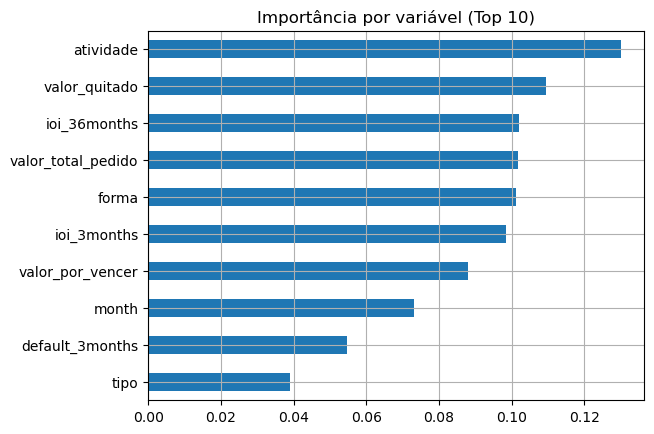

In [47]:
ax = grouped_imp.sort_values(ascending=False).head(10)[::-1].plot(kind="barh")
ax.set_title("Importância por variável (Top 10)"); ax.grid(True)
